In [561]:
import cv2
from copy import copy
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import math 
import numpy as np
import random
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.ndimage.measurements import label
from sklearn.preprocessing import RobustScaler

In [562]:
def retrive_data(noncar_size = 20):
    
    sup_path = './benchmark_velocity_supp/'
    folder_sup = os.listdir(sup_path)
    with open(os.path.join(sup_path,'annotation.json'),'r') as f:
        gt = json.load(f)
    f.close()
    imgs = []
    cars = []
    nocars = []
    #img_count=0
    for i in tqdm(gt):
        subset = i
        img = cv2.imread(os.path.join(sup_path ,subset['file_name']))
        imgs.append(img)
        aim = subset['bbox']
        coordinates = []
        for j in aim:
            left = int(j['left'])
            top = int(j['top'])
            bottom = int(j['bottom'])
            right = int(j['right'])
            car_img = img[top:bottom,left:right]
            if car_img.size:
                coordinates.append([(top - 32,bottom + 32),(left - 32,right + 32)])
                img_resized = cv2.resize(car_img,(64, 64),interpolation = cv2.INTER_CUBIC)
                cars.append(img_resized)
        n_y = int((600-270)/3)
        n_x = int((1206-64)/int(noncar_size/3))
        y_cord = range(270,600,n_y) # prevent out of range
        x_cord = range(64,1206,n_x)
        for y in y_cord:
            for x in x_cord:
                for c in coordinates:
                    if y in range(c[0][0],c[0][1]) and x in range(c[1][0],c[1][1]):
                        break
                    else:
                        nocars.append(img[y-32:y+32,x-32:x+32])
                            #imgname = "./non-vehicles/noncars/"+"noncar_img_"+str(img_count)+".jpg"
                            #cv2.imwrite(imgname, img[h-32:h+32,v-32:v+32])
                            #img_count += 1

# Read from processed images
#     nocars=[]
#     nocars_path = "./non-vehicles/noncars/"
#     for _, _, imgs in tqdm(os.walk(nocars_path)):
#         for img_name in imgs:
#             if img_name != '.DS_Store':
#                 img_path = nocars_path + img_name
#                 file = cv2.imread(img_path)
#                 nocars.append(file)
    
    return imgs, cars, nocars

In [563]:
def retrive_features(imgs, hist_bins = 32, spatial_size = (16,16), hog_orientations = 9, hog_pixels_per_cell = (8, 8), hog_cells_per_block = (1, 1)):
    img_features = []
    
    for i in tqdm(imgs):
        img = cv2.cvtColor(i,cv2.COLOR_BGR2YCrCb)
        # extract color hist features
        channel1 = np.histogram(img[:, :, 0],bins=hist_bins)
        channel2 = np.histogram(img[:, :, 1],bins=hist_bins)
        channel3 = np.histogram(img[:, :, 2],bins=hist_bins)
        hist_feature = np.concatenate((channel1[0], channel2[0], channel3[0]))
        
        # extract spatial features
        spatial_features = cv2.resize(img,spatial_size).ravel()
        
        # extract hog features
        hog_feature = hog(img, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,
                          cells_per_block=hog_cells_per_block, visualize=False,feature_vector=True)
        
        img_features.append(np.concatenate((hist_feature, spatial_features, hog_feature)))
    return img_features

In [564]:
def train(car_features,nocars_features, random_state=0):
    #print(type(car_features),len(car_features))
    #print(type(nocars_features),len(nocars_features))
    x = np.vstack((car_features, nocars_features))
    #print(type(x),x.shape)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocars_features))))
    scaler = RobustScaler().fit(x)
    x = scaler.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    svc = LinearSVC()
    svc.fit(x_train, y_train)
    predict = svc.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,predict)
    recall = metrics.recall_score(y_test,predict,average='macro')
    print(f"Accuracy:{accuracy:0.3f}\t Recall:{recall:0.3f}")
    print("SVM")
    print(metrics.confusion_matrix(y_test,predict))
    return svc,scaler

In [565]:
def slide_window(img, window_size=(64, 64), overlap=0.5):
    step = window_size[0] * (1 - overlap)
    number_of_window_x = int((img.shape[1] - window_size[0] * overlap) / step)
    number_of_window_y = int((img.shape[0] - window_size[1] * overlap) / step)
    windows = []
    for y in range(number_of_window_y):
        for x in range(number_of_window_x):
            startx = int(x * step)
            starty = int(y * step) + 270
           # change the window size based on distance 
            if starty+window_size[0]*2.5 <= img.shape[0]:
#                 if starty < 400:
#                     endy = starty + window_size[1]
#                     endx = startx + window_size[0]
#                     windows.append(((startx, starty), (endx, endy)))
#                 elif starty >= 400 and starty < 432:
#                     endy = int(starty + window_size[1])
#                     endx = int(startx + window_size[0])
#                     windows.append(((startx, starty), (endx, endy)))
#                 elif starty >= 432 and starty < 448:
#                     endy = int(starty + window_size[1])
#                     endx = int(startx + window_size[0])
#                     windows.append(((startx, starty), (endx, endy)))
#                 elif starty >= 448 and starty < 500:
#                     endy = int(starty + window_size[1])
#                     endx = int(startx + window_size[0])
#                     windows.append(((startx, starty), (endx, endy)))
                if starty < 400:
                    endy = starty + window_size[1]
                    endx = startx + window_size[0]
                    windows.append(((startx, starty), (endx, endy)))
                elif starty >= 400 and starty < 432:
                    starty = 400
                    endy = int(starty + window_size[1]*1.5)
                    endx = int(startx + window_size[0]*1.5)
                    windows.append(((startx, starty), (endx, endy)))
                elif starty >= 432 and starty < 448:
                    starty = 432
                    endy = int(starty + window_size[1]*2)
                    endx = startx + window_size[0]*2
                    windows.append(((startx, starty), (endx, endy)))
                elif starty >= 448 and starty < 500:
                    starty = 448
                    endy = int(starty+ window_size[1]*2.5)
                    endx = int(startx + window_size[0]*2.5)
                    windows.append(((startx, starty), (endx, endy)))
            
    return windows

def search(img, windows, clf,scaler,hist_bins = 32, spatial_size = (16,16), hog_orientations = 9, hog_pixels_per_cell = (8, 8), hog_cells_per_block = (1, 1)):
    result = []
    #features = []
    for window in windows:
        img_small = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        if img_small.size:
            img_small = cv2.resize(img_small, (64, 64))
            img_small = cv2.cvtColor(img_small,cv2.COLOR_BGR2YCrCb)
            
            # extract color hist features
            channel1 = np.histogram(img_small[:, :, 0],bins=hist_bins)
            channel2 = np.histogram(img_small[:, :, 1],bins=hist_bins)
            channel3 = np.histogram(img_small[:, :, 2],bins=hist_bins)
            hist_feature = np.concatenate((channel1[0], channel2[0], channel3[0]))

            # extract spatial features
            spatial_features = cv2.resize(img_small,spatial_size).ravel()

            # extract hog features
            hog_feature = hog(img_small, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,
                              cells_per_block=hog_cells_per_block, visualize=False,feature_vector=True)

            
            features = np.concatenate((hist_feature,spatial_features,hog_feature))
    #             print(type(features),features.shape)
    #             print(type(temp),temp.shape)
    #             print(type(hist_feature),hist_feature.shape)
            features = scaler.transform([features])
            if clf.predict(features):
                result.append(window)
    return result

def draw_windows(img,windows):
    draw_img = np.copy(img)
    for window in windows:
        cv2.rectangle(draw_img, window[0],window[1], (0, 0, 255), 3)
    return draw_img,windows

In [566]:
def read_train_data(train_path='./benchmark_velocity_train/clips/'):
    train_dirs = os.listdir(train_path)
    # Delete '.DS_Store' file in macOS system
    train_dirs = [i for i in train_dirs if i != '.DS_Store']
    clips_folders = list(map(int, train_dirs))
    clips_folders.sort()

    annotated_imgs = []
    for i in clips_folders:
        imgs_path = train_path + str(i) + '/imgs'
        for _, _, imgs in os.walk(imgs_path):
            imgs.sort()
            for img_name in imgs:
                img_path = imgs_path + '/' + img_name
                if '040' in img_name:
                    annotated_imgs.append(img_path)

    annotations = [os.path.join(train_path, str(x), 'annotation.json') for x in clips_folders]
    annotation_list = VeloEval.load_annotation(annotations)
    car_imgs=[]
    nocars=[]
    img_count = 0
    coordinates = []
    for anno in tqdm(annotation_list):
        top = int(anno[0]['bbox'][:, 0][0])
        left = int(anno[0]['bbox'][:, 1][0])
        bottom = int(anno[0]['bbox'][:, 2][0])
        right = int(anno[0]['bbox'][:, 3][0])
        coordinates.append([(top - 32,bottom + 32),(left - 32,right + 32)])
        img = cv2.imread(annotated_imgs[img_count])
        img_resized = cv2.resize(img[top:bottom, left:right], (64, 64), interpolation=cv2.INTER_CUBIC)
        car_imgs.append(img_resized)
        img_count += 1
    return car_imgs

In [567]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    plt.imshow(img)
    return img

In [568]:
# Taken from given source: TuSimple Competitions for CVPR2017 
# https://github.com/TuSimple/tusimple-benchmark
class VeloEval(object):
    @staticmethod
    def load_json_file(file_list):
        data_list = []
        for file_name in file_list:
            with open(file_name) as f:
                raw_data = json.load(f)
            data_list.append(raw_data)
        return data_list

    @staticmethod
    def transform_annotation(raw_data_list):
        anno_list = []
        for raw_data in raw_data_list:
            data = []
            for instance in raw_data:
                instance["bbox"] = np.array([[instance["bbox"]["top"],
                                              instance["bbox"]["left"],
                                              instance["bbox"]["bottom"],
                                              instance["bbox"]["right"]]])
                data.append(instance)
            anno_list.append(data)
        return anno_list

    @staticmethod
    def load_annotation(file_list):
        raw_data_list = VeloEval.load_json_file(file_list)
        anno_list = VeloEval.transform_annotation(raw_data_list)
        print("Finished loading {0:d} annotations.".format(len(anno_list)))
        return anno_list

In [ ]:
#train_cars = read_train_data()
img, cars, nocars = retrive_data(noncar_size=10)
#cars.extend(train_cars)
#nocars.extend(train_nocars)
print(len(cars),len(nocars))

 96%|█████████▌| 4852/5067 [01:04<00:02, 76.38it/s]

In [ ]:
# feature extraction parameters
hist_bins = 32
spatial_size = (16,16)
hog_orientations = 9
hog_pixels_per_cell = (8, 8)
hog_cells_per_block = (1, 1)

# extract features
car_features = retrive_features(cars, hist_bins, spatial_size, hog_orientations, hog_pixels_per_cell, hog_cells_per_block)
nocars_features = retrive_features(nocars,hist_bins, spatial_size, hog_orientations, hog_pixels_per_cell, hog_cells_per_block)

In [ ]:
random_state = 0

# train the features
clf,scaler = train(car_features, nocars_features, random_state)

In [ ]:
# 1, 3, 4(nocar_img), 11, 12,14, 20,25,27,42,32/35/38/49(one miss match)
# Single image car detect
overlap = 0.75
window_size= (64, 64)
single_sup_img = copy(img[3])
single_train_img = cv2.imread("./benchmark_velocity_test/clips/7/imgs/040.jpg")
img_YCrCb = cv2.cvtColor(single_sup_img,cv2.COLOR_BGR2YCrCb)
plt.imshow(img_YCrCb)

In [ ]:
windows = search(single_sup_img,slide_window(single_sup_img, window_size,overlap),clf,scaler,hist_bins, spatial_size, hog_orientations, hog_pixels_per_cell, hog_cells_per_block)
draw_img,windows = draw_windows(single_sup_img,windows)
plt.imshow(draw_img)

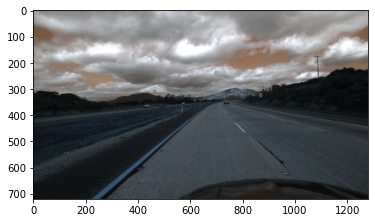

In [369]:
windows = search(single_sup_img,slide_window(single_sup_img, window_size,overlap),clf,scaler,hist_bins, spatial_size, hog_orientations, hog_pixels_per_cell, hog_cells_per_block)
draw_img,windows = draw_windows(single_sup_img,windows)
plt.imshow(draw_img)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 7)


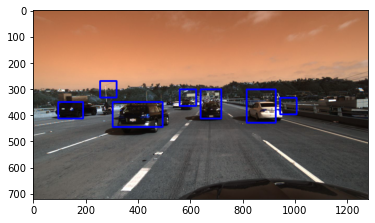

In [354]:
heat_map = np.zeros(single_sup_img.shape[:2])
heat_map = add_heat(heat_map,windows)
heat_map_thresholded = apply_threshold(heat_map,1)
labels = label(heat_map_thresholded)
draw_img = draw_labeled_bboxes(single_sup_img,labels)
#plt.imshow(heat_map)
print(labels)
#plt.imshow(draw_img)

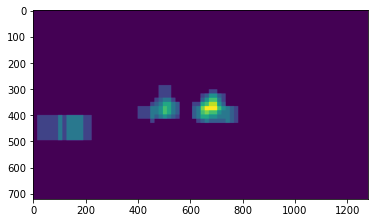

In [283]:
plt.imshow(heat_map)

In [447]:
h =[270,685,)
h

654

In [547]:
noncar_size = 20
n_h = int((600-270)/3)
n_v = int((1206-64)/int(noncar_size/3))
h = range(270,685,n_h) # prevent out of range
v = range(64,1206,n_v)

In [549]:
a = 0
for i in v:
    a += 1
    print(i)
print(a)

64
254
444
634
824
1014
1204
7
